In [125]:
# Import libraries
import pandas as pd
import numpy as np
import math
!pip install cplex
import cplex

# Strategies
 For strategies 3, 4, and 5 include mathematical formulation of optimization problem in report and/or in notebook

In [126]:

def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
   x_optimal = x_init
   cash_optimal = cash_init
   return x_optimal, cash_optimal

In [127]:

def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
  # number of stocks, should = 30
  n = 30
  # calculate portfolio value
  port_value = np.dot(cur_prices, x_init) + cash_init
  # equaly weight
  w = np.ones((30)) / n
  target_value = port_value * w
  # rounding x to integer
  x_optimal = np.floor(target_value / cur_prices)
  # find the transcation cost
  cost = np.dot(cur_prices , abs(x_optimal - x_init)) * 0.005
  # Find how much cash we left in the portfilio
  cash_optimal = port_value - np.dot(cur_prices, x_optimal) - cost

  return x_optimal, cash_optimal

In [128]:
# Mathematical formulation:
# Minimum Variance Portfolio:
# Minimize: w^T * Q * w
# Subject to: sum(w) = 1
#             w_i >= 0 for all i
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
  # number of stocks, should = 30
  n = 30
  # calculate portfolio value
  port_value = np.dot(cur_prices, x_init) + cash_init
  # use CPLEX
  cpx = cplex.Cplex()
  cpx.objective.set_sense(cpx.objective.sense.minimize)
  c  = [0.0] * n
  lb = [0.0] * n
  ub = [1.0] * n
  lst = []
  for i in range(n):
    lst.append([[0,1],[1,0]])
  # objective and constraints
  cpx.linear_constraints.add(rhs = [1.0,0], senses = 'EG')
  cpx.variables.add(obj = c, lb = lb, ub = ub, columns = lst, names = ['w%s'% i for i in range(1, n + 1)])
  # Define and add quadratic part of objective function
  qmat = [[list(range(n)), list(2 * Q[k,:])] for k in range(n)]
  cpx.objective.set_quadratic(qmat)
  # Set CPLEX parameters concurrent
  alg = cpx.parameters.lpmethod.values
  cpx.parameters.qpmethod.set(alg.concurrent)
  # Disable results output
  cpx.set_results_stream(None)
  cpx.set_warning_stream(None)
  cpx.solve()
  # get optimal w
  w = np.array(cpx.solution.get_values())
  # get optimal x
  x_optimal = np.floor(w * port_value / cur_prices)
  # find the transcation cost
  cost = np.dot(cur_prices , abs(x_optimal - x_init)) * 0.005
  # Find how much cash we left in the portfilio
  cash_optimal = port_value - np.dot(cur_prices, x_optimal) - cost

  return x_optimal, cash_optimal

In [129]:
# Mathematical formulation:
# Maximum Expected Return:
# Maximize: sum(w * mu)
# Subject to: sum(w) = 1
#             w_i >= 0 for all i
def strat_max_return(x_init, cash_init, mu, Q, cur_prices):
  n = 30  # Number of stocks
  port_value = np.dot(cur_prices, x_init) + cash_init  # Calculate portfolio value

  # Initialize CPLEX
  cpx = cplex.Cplex()
  cpx.objective.set_sense(cpx.objective.sense.maximize)

  c = list(mu)  # Objective function: maximize expected return
  lb = [0.0] * n  # Lower bound (no short selling)
  ub = [1.0] * n  # Upper bound (fully invested)

  lst = []
  for i in range(n):
    lst.append([[0, 1], [1, 0]])

  # Constraints
  cpx.linear_constraints.add(rhs=[1.0, 0], senses='EG')
  cpx.variables.add(obj=c, lb=lb, ub=ub, columns=lst, names=['w%s' % i for i in range(1, n + 1)])

  # Set CPLEX parameters
  alg = cpx.parameters.lpmethod.values
  cpx.parameters.qpmethod.set(alg.concurrent)
  cpx.set_results_stream(None)
  cpx.set_warning_stream(None)

  cpx.solve()

  # Get optimal weights and convert to shares
  w = np.array(cpx.solution.get_values())
  x_optimal = np.floor(w * port_value / cur_prices)

  # Compute transaction cost
  cost = np.dot(cur_prices, abs(x_optimal - x_init)) * 0.005
  cash_optimal = port_value - np.dot(cur_prices, x_optimal) - cost

  return x_optimal, cash_optimal

In [130]:
# Mathematical formulation:

def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
  n = 30  # Number of stocks
  port_value = np.dot(cur_prices, x_init) + cash_init  # Calculate total portfolio value

  # Annual risk-free rate for years 2020-2021 is 1.5%
  r_rf = 0.015
  daily_rf = r_rf / 252  # Convert to daily risk-free rate

  # Fix: Ensure correct size for Q1 and Q2
  Q1 = np.append(Q, np.zeros((n, 1)), axis=1)  # Add a column of zeros
  Q2 = np.vstack([Q1, np.zeros((n+1))])  # Add a row of zeros

  # Compute expected excess return
  d = mu - daily_rf * np.ones(n)

  lst = []
  for i in range(n):
      lst.append([[0,1], [d[i], 1.0]])
  lst.append([[0,1], [0, -1.0]])

  # Initialize CPLEX
  cpx = cplex.Cplex()
  cpx.objective.set_sense(cpx.objective.sense.minimize)

  c = [0] * (n + 1)  # Add space for kappa
  lb = [0] * (n + 1)
  ub = [np.inf] * (n + 1)

  var_names = [f'y{i}' for i in range(1, n + 2)]

  # Constraints
  cpx.linear_constraints.add(rhs=[1.0, 0], senses='EE')
  cpx.variables.add(obj=c, lb=lb, ub=ub, columns=lst, names=var_names)

  # Define quadratic objective function
  qmat = [[list(range(n + 1)), list(2 * Q2[k, :])] for k in range(n + 1)]
  cpx.objective.set_quadratic(qmat)

  # Solve the optimization problem
  cpx.set_results_stream(None)
  cpx.set_warning_stream(None)
  cpx.solve()

  # Retrieve solution
  result = np.array(cpx.solution.get_values())
  max_sharpe_weight = result[:n] / result[n]

  # Convert weights to share allocations
  value_each_stock = max_sharpe_weight * port_value
  x_optimal = np.floor(value_each_stock / cur_prices)

  # Compute transaction cost
  cost = np.dot(cur_prices, abs(x_optimal - x_init)) * 0.005
  cash_optimal = port_value - np.dot(cur_prices, x_optimal) - cost

  return x_optimal, cash_optimal

# Data loading and initialization of portfolios

In [131]:

# Input file
input_file_prices='adjclose_2020_2021.csv' # path to close_2020_2021 file

# Read data into a dataframe
df = pd.read_csv(input_file_prices)
df.head()

,Date,AAPL,AMD,AMT,AMZN,BAC,CAT,CSCO,CVX,DUK,...,NEE,NVDA,PFE,PG,PLD,SONY,T,UNH,VZ,XOM
0,11/01/2019,61.817669,34.889999,188.207397,89.571999,27.929407,128.996445,39.971779,92.137901,76.200760,...,52.113129,5.039887,28.648632,108.824005,76.238007,11.232944,19.861116,233.442368,45.020214,53.960381
1,11/04/2019,62.223629,36.290001,184.321365,90.233002,28.456383,131.165924,40.354244,96.387619,75.603317,...,50.762272,5.236665,28.379971,104.607033,76.525726,11.256713,19.830521,232.553772,44.647346,55.565235
2,11/05/2019,62.134228,36.150002,179.902603,90.085503,28.825262,130.674866,40.592224,96.680977,75.207695,...,50.211754,5.214526,27.969542,104.457687,74.895302,11.232944,19.973295,231.674469,44.371422,56.666153
3,11/06/2019,62.160801,35.930000,181.622894,89.788498,28.798910,129.889236,41.025681,95.063553,75.377251,...,50.295773,5.165269,28.066557,105.705223,76.351341,11.103139,20.014086,231.878113,44.841240,55.425682
4,11/07/2019,62.878220,36.279999,179.623184,89.410004,29.185356,131.246246,41.153168,96.641312,74.747490,...,49.322971,5.182931,27.810373,105.090256,76.081078,11.042805,20.100777,237.376083,45.139526,56.604134


In [132]:

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

In [133]:

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])

# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
if '2021' in input_file_prices:
    day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])
elif '2022' in input_file_prices:
    day_ind_end0 = len(np.where(dates_array[:,0]==2020)[0])

cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]


In [134]:

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3447, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19385, 0])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 1.5%
r_rf = 0.015

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_return', 'strat_max_Sharpe']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 'Maximum Expected Return Portfolio', 'Maximum Sharpe Ratio Portfolio']

N_strat = len(strategy_functions)
#N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_return, strat_max_Sharpe]


Initial portfolio value = $ 1000016.96



# Running computations and printing results

In [135]:

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if '2020' in input_file_prices:
      if dates_array[0, 0] == 20:
         cur_year  = 20 + math.floor(period/7)
      else:
         cur_year  = 2020 + math.floor(period/7)

   elif '2021' in input_file_prices:
      if dates_array[0, 0] == 21:
         cur_year  = 21 + math.floor(period/7)
      else:
         cur_year  = 2021 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))

   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio) (already check in strategy definition function)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################
      ###1. Ensure Cash Account is Non-Negative
      if cash[strategy, period - 1] < 0:
          #print(f"⚠ Adjusting Strategy {strategy_names[strategy]}: Insufficient cash in period {period}")

          # Calculate portfolio value
          port_value = np.dot(cur_prices, curr_positions) + curr_cash

          # Avoid division by zero
          if np.sum(x[strategy, period - 1]) > 0:
              ratio = x[strategy, period - 1] / np.sum(x[strategy, period - 1])
          else:
              ratio = np.zeros_like(x[strategy, period - 1])

          # Sell assets proportionally to cover negative cash
          cash_neg = abs(cash[strategy, period - 1]) * ratio
          position_neg = np.ceil(cash_neg / cur_prices)

          # Adjust holdings
          x[strategy, period - 1] = np.maximum(x[strategy, period - 1] - position_neg, 0)

          # Compute new transaction costs
          tran_cost_new = np.dot(cur_prices, abs(x[strategy, period - 1] - curr_positions)) * 0.005
          curr_val = np.dot(cur_prices, x[strategy, period - 1])

          # Update cash balance
          cash[strategy, period - 1] = port_value - curr_val - tran_cost_new

      ###2. Ensure New Portfolio is Affordable After Transaction Costs
      port_cost = np.dot(cur_prices, x[strategy, period - 1]) + np.dot(cur_prices, abs(x[strategy, period - 1] - curr_positions)) * 0.005
      if port_cost > (curr_cash + np.dot(cur_prices, curr_positions)):
          #print(f"⚠ Adjusting Strategy {strategy_names[strategy]}: Portfolio is too expensive in period {period}")

          # Reduce asset holdings proportionally
          adjustment_factor = (curr_cash + np.dot(cur_prices, curr_positions)) / port_cost
          x[strategy, period - 1] = np.floor(x[strategy, period - 1] * adjustment_factor)

          # Recalculate cash balance
          port_value = np.dot(cur_prices, x[strategy, period - 1])
          cash[strategy, period - 1] = curr_cash + np.dot(cur_prices, curr_positions) - port_value

      ###3. Ensure No Short Selling (All Holdings Non-Negative)
      x[strategy, period - 1] = np.maximum(x[strategy, period - 1], 0)

      ####### **End of Feasibility Adjustments** #######


      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}, cash account = ${3:.2f}'.format(strategy_names[strategy],
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0], cash[strategy, period-1]))

   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)



Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000016.96, value end = $ 887595.87, cash account = $0.00
  Strategy "Equally Weighted Portfolio", value begin = $ 990731.02, value end = $ 904019.44, cash account = $1318.91
  Strategy "Minimum Variance Portfolio", value begin = $ 990213.07, value end = $ 906937.18, cash account = $622.14
  Strategy "Maximum Expected Return Portfolio", value begin = $ 990066.86, value end = $ 917076.82, cash account = $63.59
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990068.97, value end = $ 919097.51, cash account = $487.11

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Buy and Hold", value begin = $ 935621.22, value end = $ 918221.82, cash account = $0.00
  Strategy "Equally Weighted Portfolio", value begin = $ 943960.50, value end = $ 890223.53, cash account = $545.05
  Strategy "Minimum Variance Portfolio", value begin = $ 938866.50, value end = $ 891202.61, cash ac

# Plot results

Plot one chart in Python that illustrates the daily value of your portfoli(for each trading
strategy) over the two years using daily adjusted closing prices provided. Include the
chart in your report.

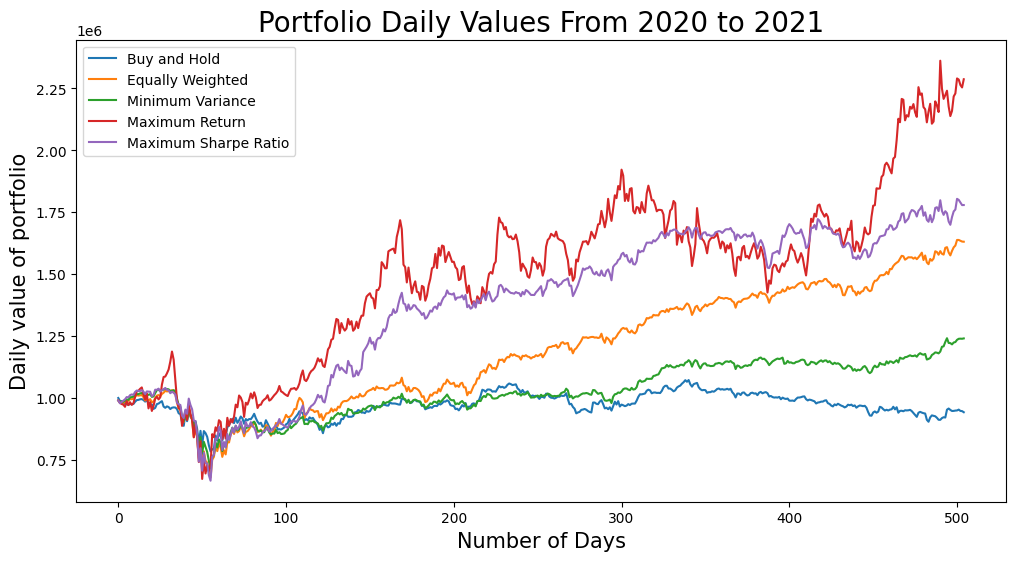

In [136]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 6))

plt.plot(portf_value[0], label = 'Buy and Hold')
plt.plot(portf_value[1], label = 'Equally Weighted')
plt.plot(portf_value[2], label = 'Minimum Variance')
plt.plot(portf_value[3], label = 'Maximum Return')
plt.plot(portf_value[4], label = 'Maximum Sharpe Ratio')

plt.title('Portfolio Daily Values From 2020 to 2021', fontsize = 20)
plt.xlabel('Number of Days', fontsize = 15)
plt.ylabel('Daily value of portfolio', fontsize = 15)
plt.legend()
plt.show()

Plot three charts in Python for strategy 3, 4, and 5 to show dynamic changes in portfolio
allocations. In each chart, x-axis represents the rolling up time horizon, y-axis denotes
portfolio weights between 0 and 1, and distinct lines display the position of selected assets
over time periods. You may use these figures to support your analysis or discussion.

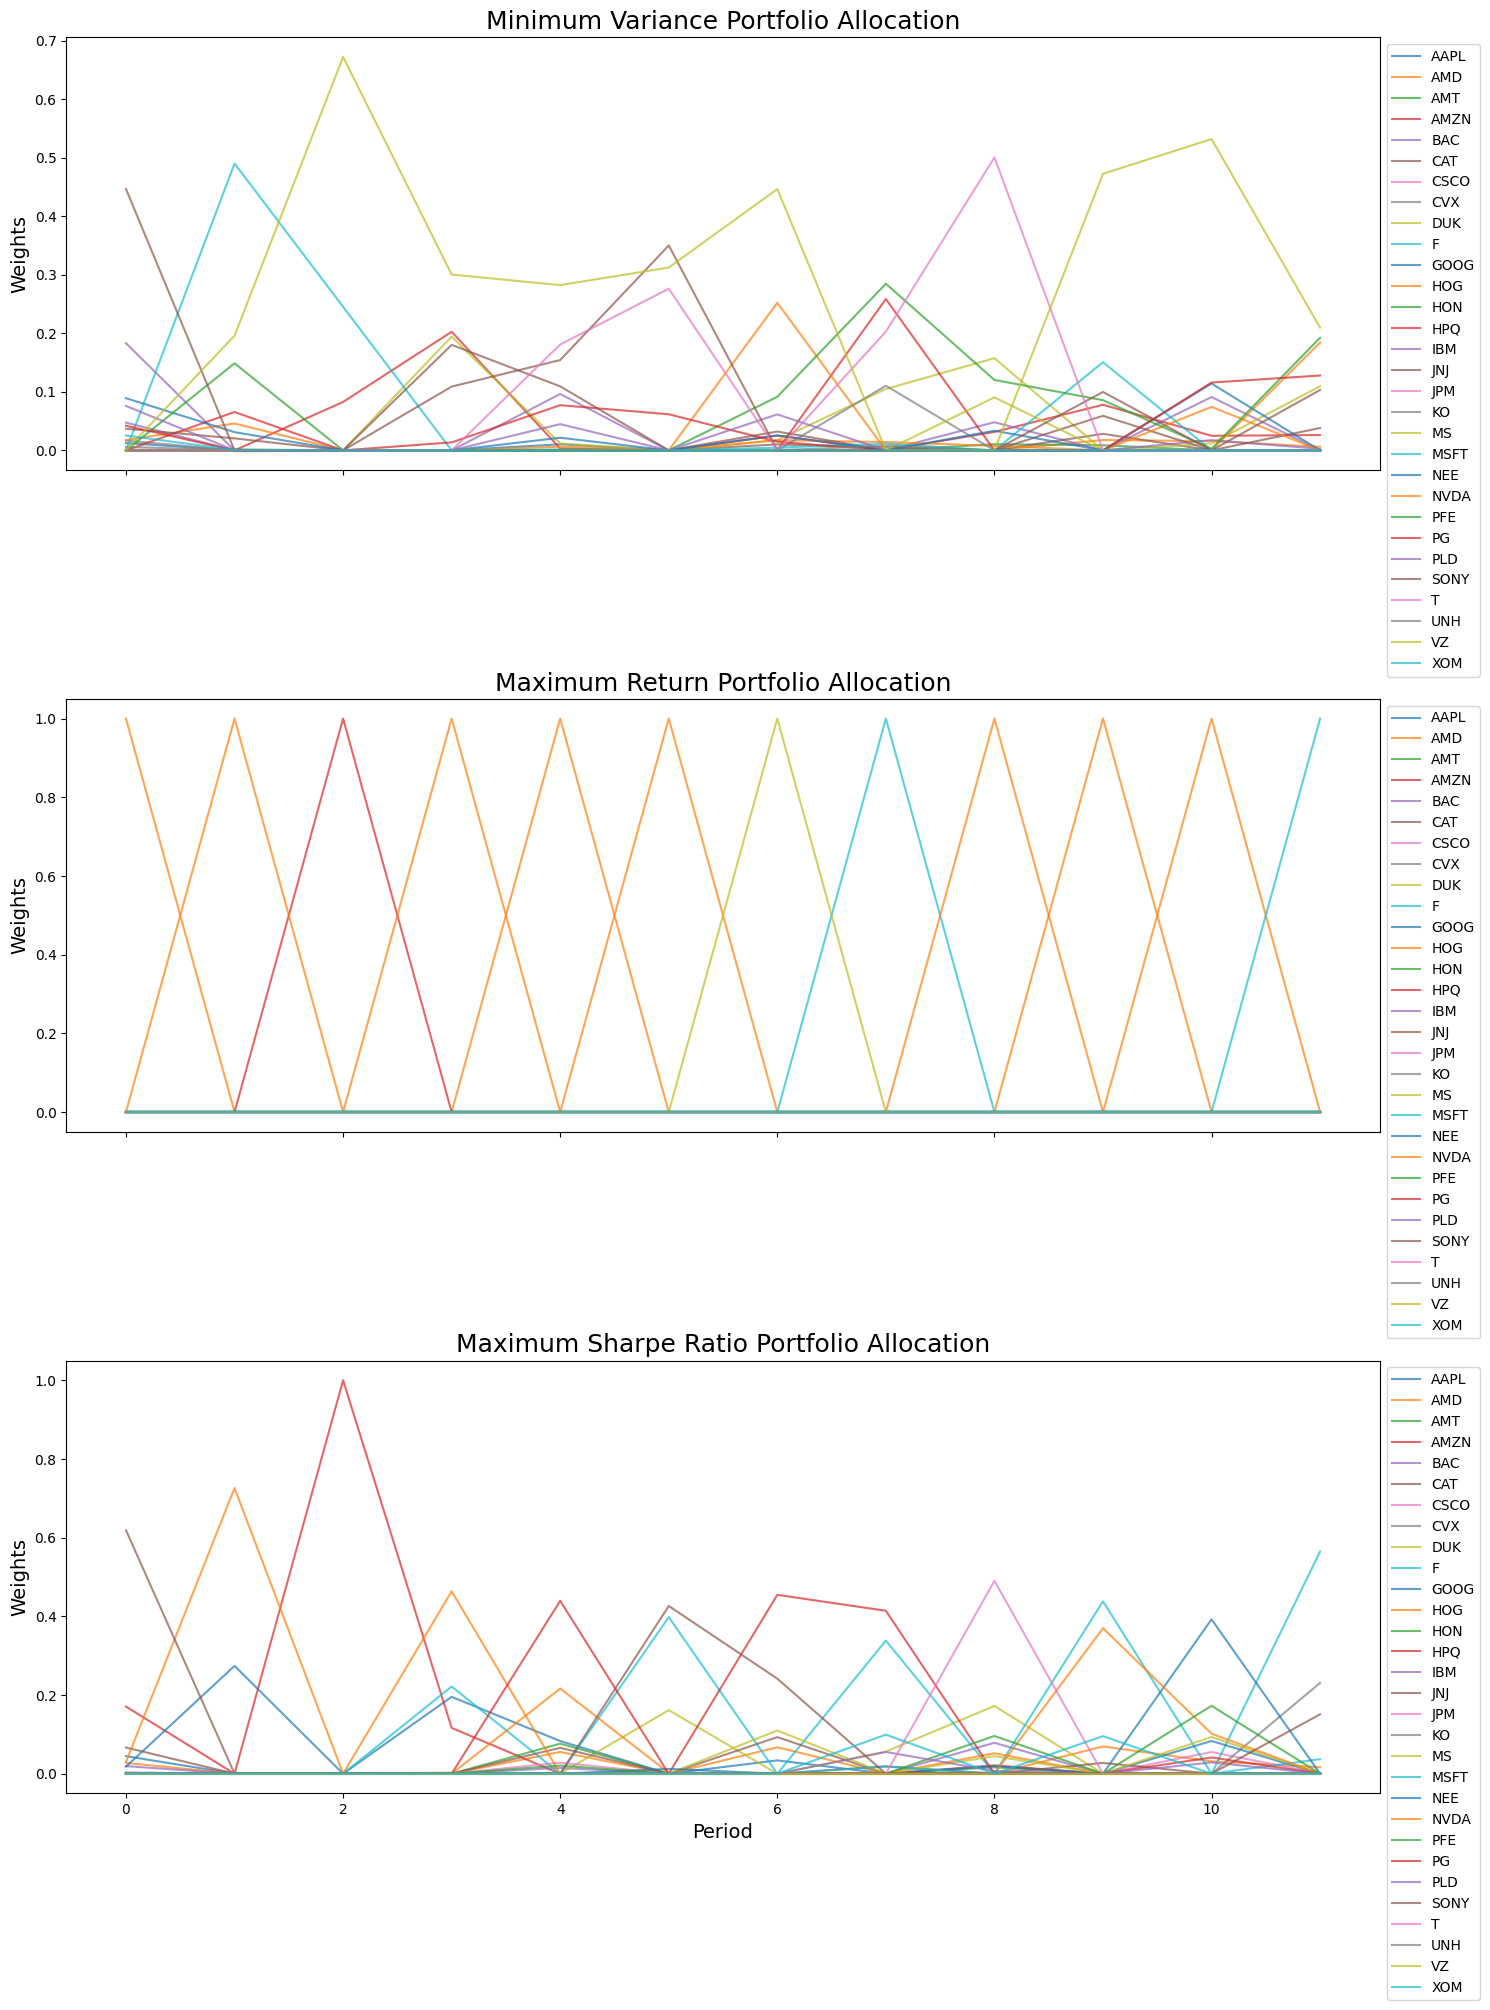

In [137]:
import numpy as np
import matplotlib.pyplot as plt

# Define strategy details
strategy_titles = [
    "Minimum Variance Portfolio Allocation",
    "Maximum Return Portfolio Allocation",
    "Maximum Sharpe Ratio Portfolio Allocation"
]

strategy_indices = [2, 3, 4]  # Corresponding indices in `x`
stocks = df.columns[1:]  # Extract stock names

# Create a figure with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(15, 20), sharex=True)

for idx, ax in enumerate(axes):
    strategy_index = strategy_indices[idx]

    for stock in range(30):
        w_period = []
        for period in range(1, N_periods + 1):
            sum_share = sum(x[strategy_index, period - 1])  # Sum of shares in portfolio
            if sum_share > 0:
                weight_period = x[strategy_index, period - 1] / sum_share
            else:
                weight_period = np.zeros_like(x[strategy_index, period - 1])
            w_period.append(weight_period[stock])

        ax.plot(w_period, alpha=0.7, label=stocks[stock])  # Reduce opacity for better visibility

    ax.set_title(strategy_titles[idx], fontsize=18)
    ax.set_ylabel('Weights', fontsize=14)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside the plot

axes[-1].set_xlabel('Period', fontsize=14)

plt.tight_layout()
plt.savefig("portfolio_allocations.png", dpi=300, bbox_inches='tight')
plt.show()


Compute the risk measures (variance, maximum drawdown, and Sharpe ratio) for the
“Maximum Expected Return” portfolio strategy over the 2020-2021 time period and
compare those to measures for other strategies.

In [138]:
# new
import numpy as np
import pandas as pd

# Compute risk measures
def compute_risk_measures(portfolio_values):
    returns = portfolio_values[1:] / portfolio_values[:-1] - 1  # Compute daily returns
    variance = np.var(returns)

    # Compute maximum drawdown
    cumulative_max = np.maximum.accumulate(portfolio_values)
    drawdown = (cumulative_max - portfolio_values) / cumulative_max
    max_drawdown = np.max(drawdown)

    # Compute Sharpe Ratio
    risk_free_rate = 0.015 / 252  # Daily risk-free rate
    std_returns = np.std(returns)
    sharpe_ratio = (np.mean(returns) - risk_free_rate) / std_returns if std_returns > 0 else 0

    return variance, max_drawdown, sharpe_ratio


# Ensure day start and end indices are lists
day_ind_start = []
day_ind_end = []

for period in range(N_periods):
    cur_year = 2020 + (period // 6)
    cur_month = 2 * (period % 6) + 1

    valid_start = [i for i, val in enumerate((dates_array[:, 0] == cur_year) & (dates_array[:, 1] == cur_month)) if val]
    valid_end = [i for i, val in enumerate((dates_array[:, 0] == cur_year) & (dates_array[:, 1] == cur_month + 1)) if val]

    # Handle missing values: fallback to first or last available index
    day_ind_start.append(min(valid_start) if valid_start else 0)
    day_ind_end.append(max(valid_end) if valid_end else len(data_prices) - 1)


# Use full daily portfolio values over the entire 2020–2021 period
portfolio_values = {
    "Min Variance": np.concatenate([
        [np.dot(data_prices[i], x[2, period]) + cash[2, period] for i in range(day_ind_start[period], day_ind_end[period] + 1)]
        for period in range(N_periods)
    ]),

    "Max Return": np.concatenate([
        [np.dot(data_prices[i], x[3, period]) + cash[3, period] for i in range(day_ind_start[period], day_ind_end[period] + 1)]
        for period in range(N_periods)
    ]),

    "Max Sharpe": np.concatenate([
        [np.dot(data_prices[i], x[4, period]) + cash[4, period] for i in range(day_ind_start[period], day_ind_end[period] + 1)]
        for period in range(N_periods)
    ]),
}

# Ensure no NaN or Inf values in portfolio values
portfolio_values = {k: np.nan_to_num(v) for k, v in portfolio_values.items()}

# Compute risk measures for each strategy
risk_measures = {strategy: compute_risk_measures(np.array(values)) for strategy, values in portfolio_values.items()}

# Convert results to DataFrame and display
risk_measures_df = pd.DataFrame.from_dict(risk_measures, orient='index', columns=['Variance', 'Max Drawdown', 'Sharpe Ratio'])
print(risk_measures_df)


              Variance  Max Drawdown  Sharpe Ratio
Min Variance  0.000177      0.309362      0.035854
Max Return    0.000898      0.433185      0.068545
Max Sharpe    0.000392      0.360010      0.065676


Test your Python program for different variations of your strategies, e.g., select “1/n”
portfolio at the beginning of period 1 and hold it till the end of period 12 (as if the rebalancing strategy required large transaction costs). Discuss if you are able to achieve
better results.

In [139]:
def strat_equally_weighted_static(x_init, cash_init, mu, Q, cur_prices):
    """
    Implements the "1/n Buy and Hold" strategy.
    - Invests equally across all assets at period 1.
    - No rebalancing (ignores `mu` and `Q`).
    """
    n = 30  # Number of assets
    port_value = np.dot(cur_prices, x_init) + cash_init  # Portfolio value

    # Compute equal weights (1/n for each asset)
    w = np.ones(n) / n

    # Target value per stock
    target_value = port_value * w

    # Convert to number of shares (rounded down)
    x_optimal = np.floor(target_value / cur_prices)

    # Compute transaction cost
    cost = np.dot(cur_prices, abs(x_optimal - x_init)) * 0.005

    # Remaining cash after initial allocation
    cash_optimal = port_value - np.dot(cur_prices, x_optimal) - cost

    return x_optimal, cash_optimal


In [140]:
# update strategy list
strategy_functions = [
    'strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance',
    'strat_max_return', 'strat_max_Sharpe', 'strat_equally_weighted_static'
]
strategy_names = [
    'Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio',
    'Maximum Expected Return Portfolio', 'Maximum Sharpe Ratio Portfolio',
    '1/n Buy and Hold (No Rebalancing)'
]

fh_array = [
    strat_buy_and_hold, strat_equally_weighted, strat_min_variance,
    strat_max_return, strat_max_Sharpe, strat_equally_weighted_static
]
N_strat = len(strategy_functions)


In [141]:
portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods), dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods), dtype=np.ndarray)

for period in range(1, N_periods+1):
    cur_year = 2020 + (period - 1) // 6
    cur_month = 2 * ((period - 1) % 6) + 1

    # Identify first and last trading days
    valid_start = [i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val]
    valid_end = [i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val]

    if valid_start:
        day_ind_start = min(valid_start)
    else:
        day_ind_start = max(0, len(dates) - 1)

    if valid_end:
        day_ind_end = max(valid_end)
    else:
        day_ind_end = min(len(dates) - 1, day_ind_start + 20)

    # Prices for the current period
    cur_prices = data_prices[day_ind_start, :]

    # Execute portfolio selection strategies
    for strategy in range(N_strat):
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period - 2]
            curr_cash = cash[strategy, period - 2]

        # **Check if this is the static strategy (only executes at period 1)**
        if strategy_names[strategy] == "1/n Buy and Hold (No Rebalancing)" and period > 1:
            x[strategy, period - 1] = x[strategy, period - 2]  # Keep previous positions
            cash[strategy, period - 1] = cash[strategy, period - 2]  # Keep previous cash balance
        else:
            # Run normal strategy
            x[strategy, period - 1], cash[strategy, period - 1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

        # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1, :], x[strategy, period - 1]) + cash[strategy, period - 1]
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))

    # Compute expected returns and covariance matrix for next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1, :] / data_prices[day_ind_start:day_ind_end, :] - 1
    mu = np.nan_to_num(np.mean(cur_returns, axis=0), nan=0.0)
    Q = np.nan_to_num(np.cov(cur_returns.T), nan=0.0)

In [142]:
portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods), dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods), dtype=np.ndarray)

for period in range(1, N_periods+1):
    cur_year = 2020 + (period - 1) // 6
    cur_month = 2 * ((period - 1) % 6) + 1

    # Identify first and last trading days
    valid_start = [i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val]
    valid_end = [i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val]

    if valid_start:
        day_ind_start = min(valid_start)
    else:
        day_ind_start = max(0, len(dates) - 1)

    if valid_end:
        day_ind_end = max(valid_end)
    else:
        day_ind_end = min(len(dates) - 1, day_ind_start + 20)

    # Prices for the current period
    cur_prices = data_prices[day_ind_start, :]

    # Execute portfolio selection strategies
    for strategy in range(N_strat):
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period - 2]
            curr_cash = cash[strategy, period - 2]

        # **Check if this is the static strategy (only executes at period 1)**
        if strategy_names[strategy] == "1/n Buy and Hold (No Rebalancing)" and period > 1:
            x[strategy, period - 1] = x[strategy, period - 2]  # Keep previous positions
            cash[strategy, period - 1] = cash[strategy, period - 2]  # Keep previous cash balance
        else:
            # Run normal strategy
            x[strategy, period - 1], cash[strategy, period - 1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

        ####### 🚀 **Strategy Feasibility Checks and Adjustments** 🚀 #######

        ### ✅ 1. Ensure Cash Account is Non-Negative
        if cash[strategy, period - 1] < 0:
            print(f"⚠ Adjusting Strategy {strategy_names[strategy]}: Insufficient cash in period {period}")

            # Calculate portfolio value
            port_value = np.dot(cur_prices, curr_positions) + curr_cash

            # Avoid division by zero
            total_holdings = np.sum(x[strategy, period - 1])
            if total_holdings > 0:
                ratio = x[strategy, period - 1] / total_holdings
            else:
                ratio = np.zeros_like(x[strategy, period - 1])  # No holdings to adjust

            # Sell assets proportionally to cover negative cash
            cash_neg = abs(cash[strategy, period - 1]) * ratio
            position_neg = np.ceil(cash_neg / cur_prices)

            # Adjust holdings
            x[strategy, period - 1] = np.maximum(x[strategy, period - 1] - position_neg, 0)

            # Compute new transaction costs
            tran_cost_new = np.dot(cur_prices, abs(x[strategy, period - 1] - curr_positions)) * 0.005
            curr_val = np.dot(cur_prices, x[strategy, period - 1])

            # Update cash balance
            cash[strategy, period - 1] = port_value - curr_val - tran_cost_new

        ### ✅ 2. Ensure New Portfolio is Affordable After Transaction Costs
        port_cost = np.dot(cur_prices, x[strategy, period - 1]) + np.dot(cur_prices, abs(x[strategy, period - 1] - curr_positions)) * 0.005
        available_funds = curr_cash + np.dot(cur_prices, curr_positions)
        if port_cost > available_funds:
            #print(f"⚠ Adjusting Strategy {strategy_names[strategy]}: Portfolio is too expensive in period {period}")

            # Reduce asset holdings proportionally
            adjustment_factor = available_funds / port_cost
            x[strategy, period - 1] = np.floor(x[strategy, period - 1] * adjustment_factor)

            # Recalculate cash balance
            port_value = np.dot(cur_prices, x[strategy, period - 1])
            cash[strategy, period - 1] = available_funds - port_value

        ### ✅ 3. Ensure No Short Selling (All Holdings Non-Negative)
        x[strategy, period - 1] = np.maximum(x[strategy, period - 1], 0)

        ####### ✅ **End of Feasibility Adjustments** ✅ #######

        # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1, :], x[strategy, period - 1]) + cash[strategy, period - 1]
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size, 1))

    # Compute expected returns and covariance matrix for next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1, :] / data_prices[day_ind_start:day_ind_end, :] - 1
    mu = np.nan_to_num(np.mean(cur_returns, axis=0), nan=0.0)
    Q = np.nan_to_num(np.cov(cur_returns.T), nan=0.0)


⚠ Adjusting Strategy Equally Weighted Portfolio: Insufficient cash in period 1
⚠ Adjusting Strategy Minimum Variance Portfolio: Insufficient cash in period 1
⚠ Adjusting Strategy Maximum Expected Return Portfolio: Insufficient cash in period 1
⚠ Adjusting Strategy Maximum Sharpe Ratio Portfolio: Insufficient cash in period 1
⚠ Adjusting Strategy 1/n Buy and Hold (No Rebalancing): Insufficient cash in period 1
⚠ Adjusting Strategy Minimum Variance Portfolio: Insufficient cash in period 2
⚠ Adjusting Strategy Maximum Expected Return Portfolio: Insufficient cash in period 2
⚠ Adjusting Strategy Maximum Sharpe Ratio Portfolio: Insufficient cash in period 2
⚠ Adjusting Strategy Minimum Variance Portfolio: Insufficient cash in period 3
⚠ Adjusting Strategy Maximum Expected Return Portfolio: Insufficient cash in period 3
⚠ Adjusting Strategy Maximum Sharpe Ratio Portfolio: Insufficient cash in period 3
⚠ Adjusting Strategy Minimum Variance Portfolio: Insufficient cash in period 4
⚠ Adjusting 

In [143]:
# Ensure day start and end indices are lists
day_ind_start = []
day_ind_end = []

for period in range(N_periods):
    cur_year = 2020 + (period // 6)
    cur_month = 2 * (period % 6) + 1

    valid_start = [i for i, val in enumerate((dates_array[:, 0] == cur_year) & (dates_array[:, 1] == cur_month)) if val]
    valid_end = [i for i, val in enumerate((dates_array[:, 0] == cur_year) & (dates_array[:, 1] == cur_month + 1)) if val]

    # Handle missing values: fallback to first or last available index
    day_ind_start.append(min(valid_start) if valid_start else 0)
    day_ind_end.append(max(valid_end) if valid_end else len(data_prices) - 1)


# Use full daily portfolio values over the entire 2020–2021 period
portfolio_values = {
    "Min Variance": np.concatenate([
        [np.dot(data_prices[i], x[2, period]) + cash[2, period] for i in range(day_ind_start[period], day_ind_end[period] + 1)]
        for period in range(N_periods)
    ]),

    "Max Return": np.concatenate([
        [np.dot(data_prices[i], x[3, period]) + cash[3, period] for i in range(day_ind_start[period], day_ind_end[period] + 1)]
        for period in range(N_periods)
    ]),

    "Max Sharpe": np.concatenate([
        [np.dot(data_prices[i], x[4, period]) + cash[4, period] for i in range(day_ind_start[period], day_ind_end[period] + 1)]
        for period in range(N_periods)
    ]),

    "1/n Buy and Hold (No Rebalancing)": np.concatenate([
        [np.dot(data_prices[i], x[5, period]) + cash[5, period] for i in range(day_ind_start[period], day_ind_end[period] + 1)]
        for period in range(N_periods)
    ])
}

# Ensure no NaN or Inf values in portfolio values
portfolio_values = {k: np.nan_to_num(v) for k, v in portfolio_values.items()}

# Compute risk measures for each strategy
risk_measures = {strategy: compute_risk_measures(np.array(values)) for strategy, values in portfolio_values.items()}

# Convert results to DataFrame and display
risk_measures_df = pd.DataFrame.from_dict(risk_measures, orient='index', columns=['Variance', 'Max Drawdown', 'Sharpe Ratio'])
print(risk_measures_df)


                                   Variance  Max Drawdown  Sharpe Ratio
Min Variance                       0.000178      0.294112      0.038475
Max Return                         0.000842      0.391140      0.064924
Max Sharpe                         0.000394      0.364347      0.066399
1/n Buy and Hold (No Rebalancing)  0.000278      0.337318      0.065921


To potentially reduce risk measures for the “Maximum Expected Return” portfolio strategy, apply sector diversification constraints by ensuring that the total weight of stocks
in each sector is between 0% and 25%. Then, compare your results with those in the
previous section.bold text

In [144]:
def strat_max_return_with_sector_constraints(x_init, cash_init, mu, Q, cur_prices):
    n = 30  # Number of stocks
    port_value = np.dot(cur_prices, x_init) + cash_init  # Portfolio value

    # Define sector indices
    sector_indices = {
        "Technology": [0, 1, 2, 3, 4, 5, 6, 7],
        "Financial Services": [8, 9, 10],
        "Healthcare": [11, 12, 13],
        "Consumer Cyclical": [14, 15, 16],
        "Consumer Defensive": [17, 18],
        "Energy": [19, 20],
        "Real Estate": [21, 22],
        "Communication Services": [23, 24, 25],
        "Industrials": [26, 27],
        "Utilities": [28, 29]
    }

    # Initialize CPLEX
    cpx = cplex.Cplex()
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.objective.set_sense(cpx.objective.sense.maximize)

    # Objective function: maximize expected return
    c = list(mu)
    lb = [0.0] * n  # Lower bound (no short selling)
    ub = [1.0] * n  # Upper bound (fully invested)

    # Add decision variables
    cpx.variables.add(obj=c, lb=lb, ub=ub, names=['w%s' % i for i in range(n)])

    # Budget constraint: sum(w) = 1
    cpx.linear_constraints.add(
        lin_expr=[cplex.SparsePair(ind=['w%s' % i for i in range(n)], val=[1.0] * n)],
        senses="E",
        rhs=[1.0],
        names=["budget"]
    )

    # Add sector constraints: each sector weight must be between 0% and 25%
    for sector, indices in sector_indices.items():
        sector_vars = ['w%s' % i for i in indices]
        sector_weights = [1.0] * len(indices)

        # Constraint: sum(w_i) ≤ 0.25
        cpx.linear_constraints.add(
            lin_expr=[cplex.SparsePair(ind=sector_vars, val=sector_weights)],
            senses="L",
            rhs=[0.25],
            names=[f"sector_{sector}_max"]
        )

    # Solve optimization problem
    try:
        cpx.solve()
        w = np.array(cpx.solution.get_values())  # Get optimal weights
    except cplex.exceptions.CplexSolverError as e:
        print(f"CPLEX Solver Error: {e}")
        return x_init, cash_init  # Return the initial portfolio if optimization fails

    # Convert weights to shares
    x_optimal = np.floor(w * port_value / cur_prices)

    # Compute transaction cost
    cost = np.dot(cur_prices, abs(x_optimal - x_init)) * 0.005
    cash_optimal = port_value - np.dot(cur_prices, x_optimal) - cost

    return x_optimal, cash_optimal


In [145]:
# update the strategies
# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_return', 'strat_max_Sharpe', 'strat_max_return_with_sector_constraints']
strategy_names = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 'Maximum Expected Return Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Maximum Expected Return with Sector Constraints Portfolio']

N_strat = len(strategy_functions)
#N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_return, strat_max_Sharpe, strat_max_return_with_sector_constraints]

# compute again to update new strategy values in x
portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if '2020' in input_file_prices:
      if dates_array[0, 0] == 20:
         cur_year  = 20 + math.floor(period/7)
      else:
         cur_year  = 2020 + math.floor(period/7)

   elif '2021' in input_file_prices:
      if dates_array[0, 0] == 21:
         cur_year  = 21 + math.floor(period/7)
      else:
         cur_year  = 2021 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   #day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   #day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])

   # debug
   valid_start = [i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val]
   valid_end = [i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val]

   # Set start of period safely
   if valid_start:
       day_ind_start = min(valid_start)
   else:
       print(f"Warning: No data found for period {period} start. Using last available index.")
       day_ind_start = max(0, len(dates) - 1)  # Prevent negative indexing

   # Set end of period safely
   if valid_end:
       day_ind_end = max(valid_end)
   else:
       print(f"Warning: No data found for period {period} end. Using last available index.")
       day_ind_end = min(len(dates) - 1, day_ind_start + 20)  # Ensure it stays within bounds

   # Final check to prevent out-of-bounds indexing
   day_ind_start = min(day_ind_start, len(dates) - 1)
   day_ind_end = min(day_ind_end, len(dates) - 1)

   # Debugging print statement
   print(f"Period {period}: day_ind_start = {day_ind_start}, day_ind_end = {day_ind_end}, dataset size = {len(dates)}")

   # Now, safely print the period dates
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))

   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio) (already check in strategy definition function)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################
      ###1. Ensure Cash Account is Non-Negative
      if cash[strategy, period - 1] < 0:
          #print(f"⚠ Adjusting Strategy {strategy_names[strategy]}: Insufficient cash in period {period}")

          # Calculate portfolio value
          port_value = np.dot(cur_prices, curr_positions) + curr_cash

          # Avoid division by zero
          if np.sum(x[strategy, period - 1]) > 0:
              ratio = x[strategy, period - 1] / np.sum(x[strategy, period - 1])
          else:
              ratio = np.zeros_like(x[strategy, period - 1])

          # Sell assets proportionally to cover negative cash
          cash_neg = abs(cash[strategy, period - 1]) * ratio
          position_neg = np.ceil(cash_neg / cur_prices)

          # Adjust holdings
          x[strategy, period - 1] = np.maximum(x[strategy, period - 1] - position_neg, 0)

          # Compute new transaction costs
          tran_cost_new = np.dot(cur_prices, abs(x[strategy, period - 1] - curr_positions)) * 0.005
          curr_val = np.dot(cur_prices, x[strategy, period - 1])

          # Update cash balance
          cash[strategy, period - 1] = port_value - curr_val - tran_cost_new

      ###2. Ensure New Portfolio is Affordable After Transaction Costs
      port_cost = np.dot(cur_prices, x[strategy, period - 1]) + np.dot(cur_prices, abs(x[strategy, period - 1] - curr_positions)) * 0.005
      if port_cost > (curr_cash + np.dot(cur_prices, curr_positions)):
          #print(f"⚠ Adjusting Strategy {strategy_names[strategy]}: Portfolio is too expensive in period {period}")

          # Reduce asset holdings proportionally
          adjustment_factor = (curr_cash + np.dot(cur_prices, curr_positions)) / port_cost
          x[strategy, period - 1] = np.floor(x[strategy, period - 1] * adjustment_factor)

          # Recalculate cash balance
          port_value = np.dot(cur_prices, x[strategy, period - 1])
          cash[strategy, period - 1] = curr_cash + np.dot(cur_prices, curr_positions) - port_value

      ###3. Ensure No Short Selling (All Holdings Non-Negative)
      x[strategy, period - 1] = np.maximum(x[strategy, period - 1], 0)

      ####### **End of Feasibility Adjustments** #######

      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}, cash account = ${3:.2f}'.format(strategy_names[strategy],
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0], cash[strategy, period-1]))

   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)


Period 1: day_ind_start = 0, day_ind_end = 39, dataset size = 505

Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000016.96, value end = $ 887595.87, cash account = $0.00
  Strategy "Equally Weighted Portfolio", value begin = $ 990731.02, value end = $ 904019.44, cash account = $1318.91
  Strategy "Minimum Variance Portfolio", value begin = $ 993591.33, value end = $ 912726.34, cash account = $442.46
  Strategy "Maximum Expected Return Portfolio", value begin = $ 990066.88, value end = $ 854021.19, cash account = $67.29
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990067.81, value end = $ 919571.22, cash account = $254.18
  Strategy "Maximum Expected Return with Sector Constraints Portfolio", value begin = $ 990066.96, value end = $ 873279.21, cash account = $83.85
Period 2: day_ind_start = 40, day_ind_end = 82, dataset size = 505

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Buy and Hold", value begi

In [146]:
# Compute risk measures
# Ensure day start and end indices are lists
day_ind_start = []
day_ind_end = []

for period in range(N_periods):
    cur_year = 2020 + (period // 6)
    cur_month = 2 * (period % 6) + 1

    valid_start = [i for i, val in enumerate((dates_array[:, 0] == cur_year) & (dates_array[:, 1] == cur_month)) if val]
    valid_end = [i for i, val in enumerate((dates_array[:, 0] == cur_year) & (dates_array[:, 1] == cur_month + 1)) if val]

    # Handle missing values: fallback to first or last available index
    day_ind_start.append(min(valid_start) if valid_start else 0)
    day_ind_end.append(max(valid_end) if valid_end else len(data_prices) - 1)


# Use full daily portfolio values over the entire 2020–2021 period
portfolio_values = {
    "Min Variance": np.concatenate([
        [np.dot(data_prices[i], x[2, period]) + cash[2, period] for i in range(day_ind_start[period], day_ind_end[period] + 1)]
        for period in range(N_periods)
    ]),

    "Max Return": np.concatenate([
        [np.dot(data_prices[i], x[3, period]) + cash[3, period] for i in range(day_ind_start[period], day_ind_end[period] + 1)]
        for period in range(N_periods)
    ]),

    "Max Sharpe": np.concatenate([
        [np.dot(data_prices[i], x[4, period]) + cash[4, period] for i in range(day_ind_start[period], day_ind_end[period] + 1)]
        for period in range(N_periods)
    ]),

    "Max Return with Sector Constraints": np.concatenate([
        [np.dot(data_prices[i], x[5, period]) + cash[5, period] for i in range(day_ind_start[period], day_ind_end[period] + 1)]
        for period in range(N_periods)
    ])
}

# Ensure no NaN or Inf values in portfolio values
portfolio_values = {k: np.nan_to_num(v) for k, v in portfolio_values.items()}

# Compute risk measures for each strategy
risk_measures = {strategy: compute_risk_measures(np.array(values)) for strategy, values in portfolio_values.items()}

# Convert results to DataFrame and display
risk_measures_df = pd.DataFrame.from_dict(risk_measures, orient='index', columns=['Variance', 'Max Drawdown', 'Sharpe Ratio'])
print(risk_measures_df)


                                    Variance  Max Drawdown  Sharpe Ratio
Min Variance                        0.000178      0.294112      0.038475
Max Return                          0.000842      0.391140      0.064924
Max Sharpe                          0.000394      0.364347      0.066399
Max Return with Sector Constraints  0.000442      0.386935      0.060084


# Repeat for years 2023-2024

In [147]:

# Input file
input_file_prices_new='adjclose_2023_2024.csv' # path to close_2023_2024 file

# Read data into a dataframe
df_new = pd.read_csv(input_file_prices_new)

# Initial positions in the portfolio
init_positions_new = np.array([0, 0, 0, 0, 0, 0, 0, 3542, 0, 0, 0, 10904, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Annual risk-free rate for years 2023-2024 is 4.5%
r_rf2023_2024 = 0.045

df_new.head()

,Date,AAPL,AMD,AMT,AMZN,BAC,CAT,CSCO,CVX,DUK,...,NEE,NVDA,PFE,PG,PLD,SONY,T,UNH,VZ,XOM
0,11/01/2022,148.835358,59.660000,193.014893,96.790001,34.036701,209.966949,42.428371,166.799332,85.377228,...,73.066513,13.529696,42.214886,127.567581,101.562935,14.462732,15.989259,529.248962,32.069881,103.810005
1,11/02/2022,143.283066,58.630001,190.517242,92.120003,33.933277,206.161606,41.597729,163.394135,84.593948,...,72.662216,13.206013,41.388359,125.732750,99.869431,13.946835,16.058969,525.497070,32.361668,101.676476
2,11/03/2022,137.207138,60.110001,186.933289,89.300003,33.745220,210.697281,40.925743,165.801575,84.903610,...,73.508438,13.407814,41.299664,124.872101,101.057693,14.095349,15.832418,525.671082,31.881092,103.058624
3,11/04/2022,136.939957,62.189999,189.338058,90.980003,34.591442,218.951797,41.551064,167.897797,85.258820,...,74.091385,14.142093,41.876110,127.151421,100.692795,14.576074,15.963122,520.410522,31.958328,104.181038
4,11/07/2022,137.474335,63.080002,187.573944,90.529999,34.798290,219.682129,41.579063,169.902451,84.001938,...,72.671608,14.286950,41.760818,129.099747,101.918472,14.753902,15.997972,527.034546,31.915419,105.414787


In [148]:
# Repeate the previous calculation for the time period 2023-2024
###################### Insert your code here ############################

# update the max_sharpe strategy: change risk-free rate
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
  n = 30  # Number of stocks
  port_value = np.dot(cur_prices, x_init) + cash_init  # Calculate total portfolio value

  r_rf = 0.045
  daily_rf = r_rf / 252  # Convert to daily risk-free rate

  # Fix: Ensure correct size for Q1 and Q2
  Q1 = np.append(Q, np.zeros((n, 1)), axis=1)  # Add a column of zeros
  Q2 = np.vstack([Q1, np.zeros((n+1))])  # Add a row of zeros

  # Compute expected excess return
  d = mu - daily_rf * np.ones(n)

  lst = []
  for i in range(n):
      lst.append([[0,1], [d[i], 1.0]])
  lst.append([[0,1], [0, -1.0]])

  # Initialize CPLEX
  cpx = cplex.Cplex()
  cpx.objective.set_sense(cpx.objective.sense.minimize)

  c = [0] * (n + 1)  # Add space for kappa
  lb = [0] * (n + 1)
  ub = [np.inf] * (n + 1)

  var_names = [f'y{i}' for i in range(1, n + 2)]

  # Constraints
  cpx.linear_constraints.add(rhs=[1.0, 0], senses='EE')
  cpx.variables.add(obj=c, lb=lb, ub=ub, columns=lst, names=var_names)

  # Define quadratic objective function
  qmat = [[list(range(n + 1)), list(2 * Q2[k, :])] for k in range(n + 1)]
  cpx.objective.set_quadratic(qmat)

  # Solve the optimization problem
  cpx.set_results_stream(None)
  cpx.set_warning_stream(None)
  cpx.solve()

  # Retrieve solution
  result = np.array(cpx.solution.get_values())
  max_sharpe_weight = result[:n] / result[n]

  # Convert weights to share allocations
  value_each_stock = max_sharpe_weight * port_value
  x_optimal = np.floor(value_each_stock / cur_prices)

  # Compute transaction cost
  cost = np.dot(cur_prices, abs(x_optimal - x_init)) * 0.005
  cash_optimal = port_value - np.dot(cur_prices, x_optimal) - cost

  return x_optimal, cash_optimal

In [149]:
dates_array = np.array(list(df_new['Date'].apply(convert_date_to_array)))
data_prices = df_new.iloc[:, 1:].to_numpy()
dates = np.array(df_new['Date'])

# Find the number of trading days in Nov-Dec 2022 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
if '2024' in input_file_prices_new:
    day_ind_end0 = len(np.where(dates_array[:,0]==2022)[0])
elif '2025' in input_file_prices_new:
    day_ind_end0 = len(np.where(dates_array[:,0]==2023)[0])

cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2022
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]


In [150]:
# Initial positions in the portfolio
init_positions_new = np.array([0, 0, 0, 0, 0, 0, 0, 3542, 0, 0, 0, 10904, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions_new)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions_new) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df_new.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2023-2024 is 4.5%
r_rf = 0.045

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_return', 'strat_max_Sharpe']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 'Maximum Expected Return Portfolio', 'Maximum Sharpe Ratio Portfolio']

N_strat = len(strategy_functions)
#N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_return, strat_max_Sharpe]


Initial portfolio value = $ 1000013.01



In [151]:
portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if '2023' in input_file_prices_new:
      if dates_array[0, 0] == 23:
         cur_year  = 23 + math.floor(period/7)
      else:
         cur_year  = 2023 + math.floor(period/7)

   elif '2024' in input_file_prices_new:
      if dates_array[0, 0] == 24:
         cur_year  = 24 + math.floor(period/7)
      else:
         cur_year  = 2024 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))

   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio) (already check in strategy definition function)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################
      ###1. Ensure Cash Account is Non-Negative
      if cash[strategy, period - 1] < 0:
          #print(f"⚠ Adjusting Strategy {strategy_names[strategy]}: Insufficient cash in period {period}")

          # Calculate portfolio value
          port_value = np.dot(cur_prices, curr_positions) + curr_cash

          # Avoid division by zero
          if np.sum(x[strategy, period - 1]) > 0:
              ratio = x[strategy, period - 1] / np.sum(x[strategy, period - 1])
          else:
              ratio = np.zeros_like(x[strategy, period - 1])

          # Sell assets proportionally to cover negative cash
          cash_neg = abs(cash[strategy, period - 1]) * ratio
          position_neg = np.ceil(cash_neg / cur_prices)

          # Adjust holdings
          x[strategy, period - 1] = np.maximum(x[strategy, period - 1] - position_neg, 0)

          # Compute new transaction costs
          tran_cost_new = np.dot(cur_prices, abs(x[strategy, period - 1] - curr_positions)) * 0.005
          curr_val = np.dot(cur_prices, x[strategy, period - 1])

          # Update cash balance
          cash[strategy, period - 1] = port_value - curr_val - tran_cost_new

      ###2. Ensure New Portfolio is Affordable After Transaction Costs
      port_cost = np.dot(cur_prices, x[strategy, period - 1]) + np.dot(cur_prices, abs(x[strategy, period - 1] - curr_positions)) * 0.005
      if port_cost > (curr_cash + np.dot(cur_prices, curr_positions)):
          #print(f"⚠ Adjusting Strategy {strategy_names[strategy]}: Portfolio is too expensive in period {period}")

          # Reduce asset holdings proportionally
          adjustment_factor = (curr_cash + np.dot(cur_prices, curr_positions)) / port_cost
          x[strategy, period - 1] = np.floor(x[strategy, period - 1] * adjustment_factor)

          # Recalculate cash balance
          port_value = np.dot(cur_prices, x[strategy, period - 1])
          cash[strategy, period - 1] = curr_cash + np.dot(cur_prices, curr_positions) - port_value

      ###3. Ensure No Short Selling (All Holdings Non-Negative)
      x[strategy, period - 1] = np.maximum(x[strategy, period - 1], 0)

      ####### **End of Feasibility Adjustments** #######


      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}, cash account = ${3:.2f}'.format(strategy_names[strategy],
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0], cash[strategy, period-1]))

   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)



Period 1: start date 01/03/2023, end date 02/28/2023
  Strategy "Buy and Hold", value begin = $ 803839.20, value end = $ 813527.97, cash account = $0.00
  Strategy "Equally Weighted Portfolio", value begin = $ 796379.57, value end = $ 820275.20, cash account = $2161.08
  Strategy "Minimum Variance Portfolio", value begin = $ 796325.02, value end = $ 733233.62, cash account = $99.88
  Strategy "Maximum Expected Return Portfolio", value begin = $ 795841.25, value end = $ 726819.74, cash account = $90.20
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 795841.61, value end = $ 724189.69, cash account = $164.32

Period 2: start date 03/01/2023, end date 04/28/2023
  Strategy "Buy and Hold", value begin = $ 804711.35, value end = $ 790485.55, cash account = $0.00
  Strategy "Equally Weighted Portfolio", value begin = $ 815139.89, value end = $ 852012.59, cash account = $1339.30
  Strategy "Minimum Variance Portfolio", value begin = $ 721823.47, value end = $ 748381.87, cash acc

# Plot the results for years 2023-2024

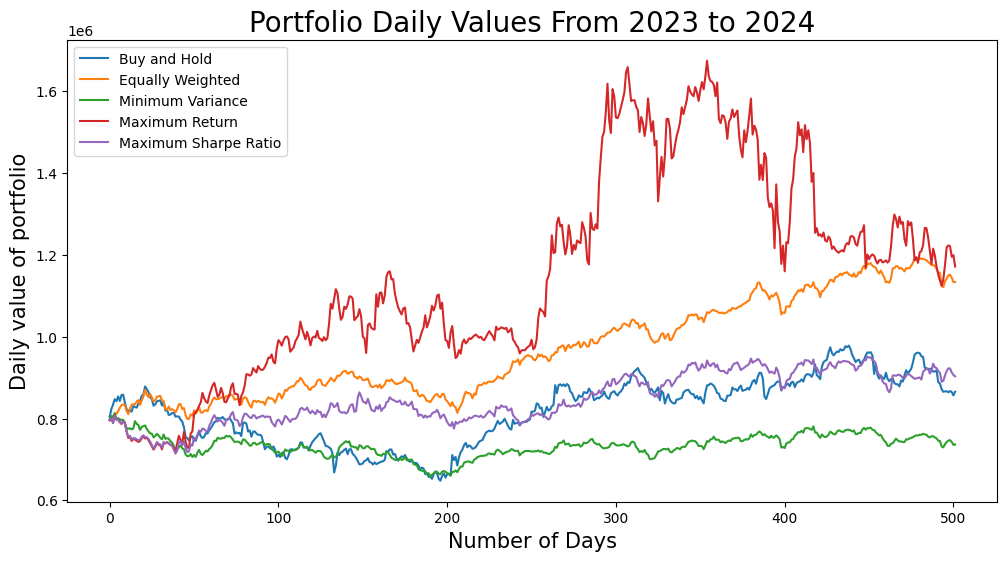

In [152]:

# Plot results for 2023-2024
###################### Insert your code here ############################
plt.figure(figsize = (12, 6))

plt.plot(portf_value[0], label = 'Buy and Hold')
plt.plot(portf_value[1], label = 'Equally Weighted')
plt.plot(portf_value[2], label = 'Minimum Variance')
plt.plot(portf_value[3], label = 'Maximum Return')
plt.plot(portf_value[4], label = 'Maximum Sharpe Ratio')

plt.title('Portfolio Daily Values From 2023 to 2024', fontsize = 20)
plt.xlabel('Number of Days', fontsize = 15)
plt.ylabel('Daily value of portfolio', fontsize = 15)
plt.legend()
plt.show()